<a href="https://colab.research.google.com/github/somkat16/DS-projects/blob/main/Runner_Prediction_Times.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as data
import tensorflow as tf

In [3]:
file_path = '/content/Track_Results.xlsx'
df_track = pd.read_excel(file_path, sheet_name='Sheet7')

def conversion_time(time_str):
    try:
        minutes, seconds = map(float, time_str.split(':'))
        return minutes * 60 + seconds
    except:
        return np.nan

df_track['Time_seconds'] = df_track['Time '].astype(str).apply(conversion_time)
df_clean = df_track.dropna(subset=['Time_seconds'])
del df_track['Date']


df_clean


,Name,Time (minutes),Event,Date,Time,Date2,Time_seconds
0,"Appleton, Margo",00:04:11,ACC Outdoor Track & Field Championships,"May 15-17, 2025",4:11.00,2025-05-15,251.00
1,"Appleton, Margo",00:04:16.320000,ACC Outdoor Track & Field Championships,"May 16-17, 2025",4:16.32,2025-05-16,256.32
2,"Appleton, Margo",00:04:05.680000,Raleigh Relays,"Mar 27-29, 2025",4:05.68,2025-03-27,245.68
3,"Appleton, Margo",00:04:28.310000,ACC Outdoor Track & Field Championships,"May 9-11, 2024",4:28.31,2024-05-09,268.31
4,"Appleton, Margo",00:04:11.040000,ACC Outdoor Track & Field Championships,"May 10-11, 2024",4:11.04,2024-05-10,251.04
...,...,...,...,...,...,...,...
296,"Flockhart, Shannon",00:04:10.800000,NCAA East Preliminary Round,"May 25-28, 2022",4:10.80,2022-05-25,250.80
297,"Flockhart, Shannon",00:04:13.910000,NCAA East Preliminary Round,"May 25-28, 2022",4:13.91,2022-05-25,253.91
298,"Flockhart, Shannon",00:04:20.430000,BIG EAST Outdoor Track & Field Championships,"May 13-14, 2022",4:20.43,2022-05-13,260.43
299,"Flockhart, Shannon",00:04:24.710000,BIG EAST Outdoor Track & Field Championships,"May 13-14, 2022",4:24.71,2022-05-13,264.71


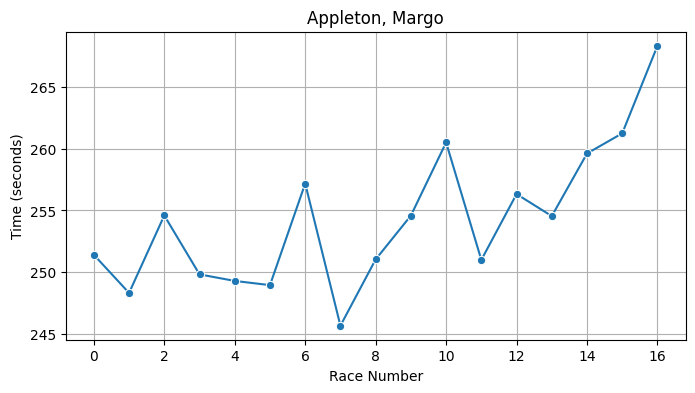

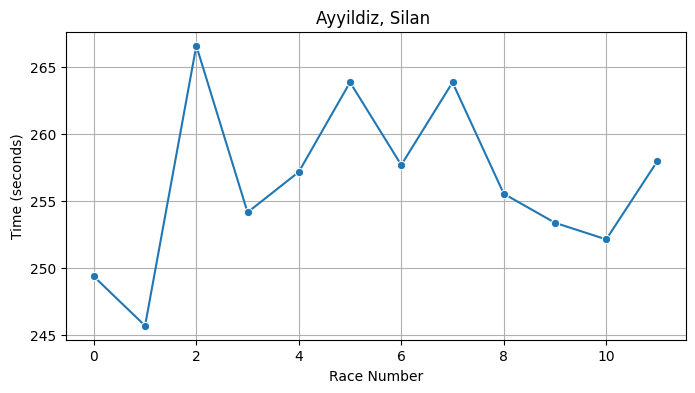

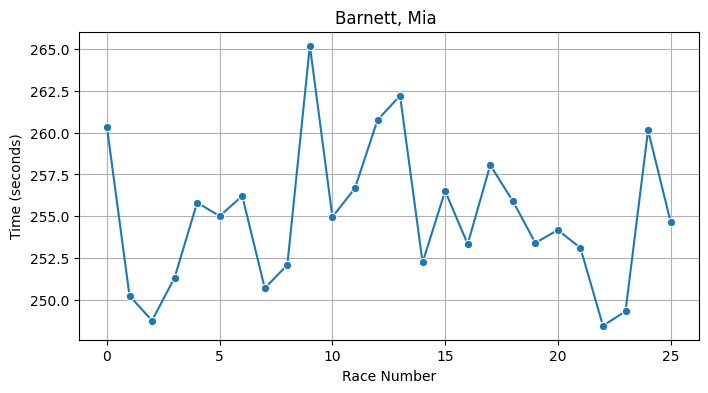

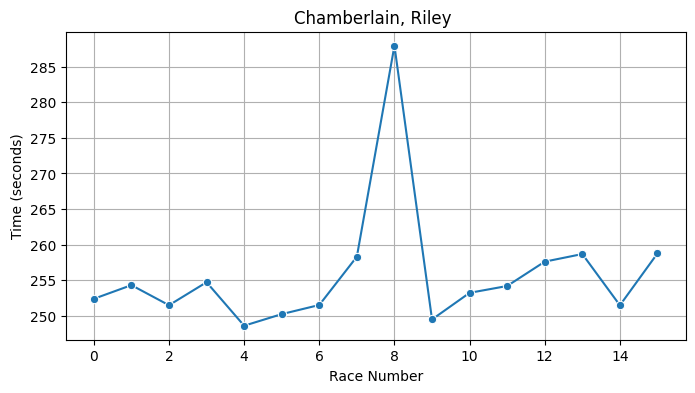

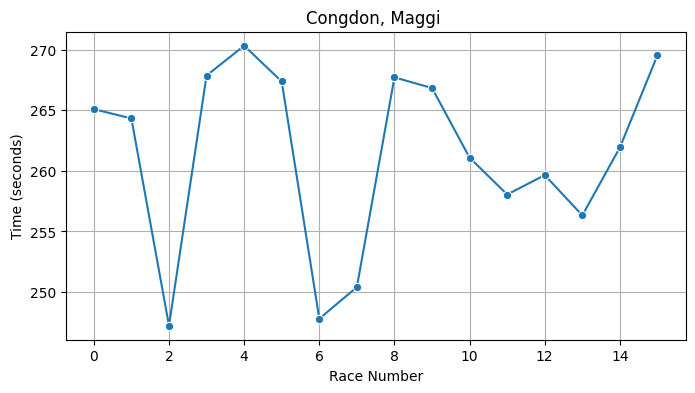

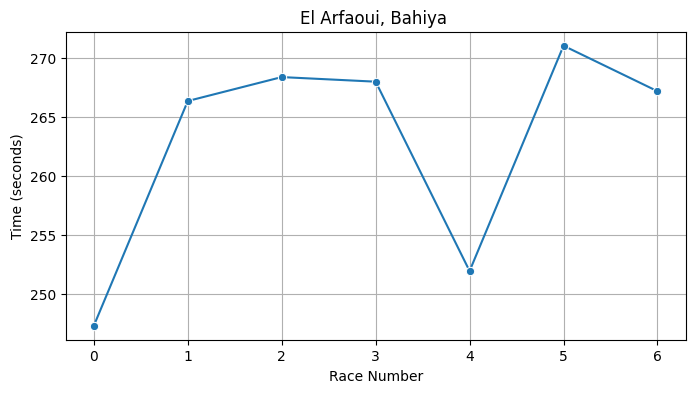

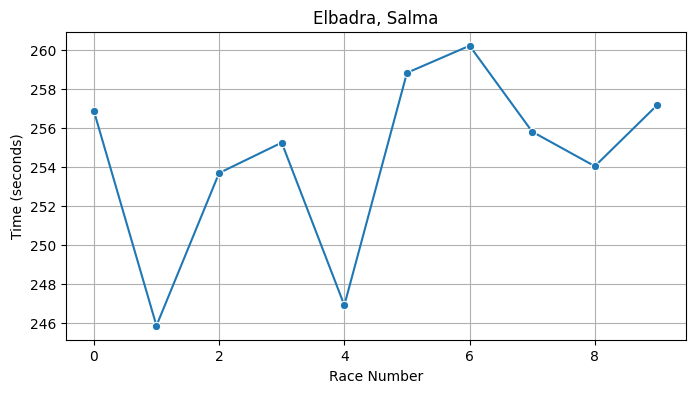

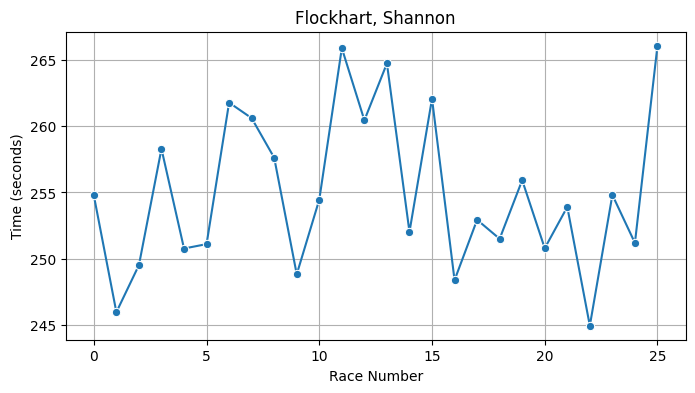

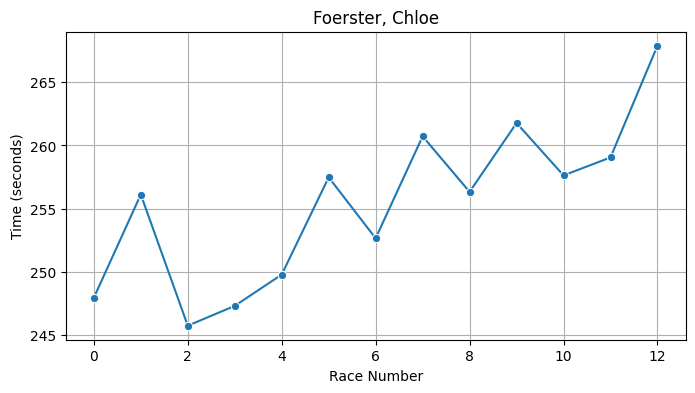

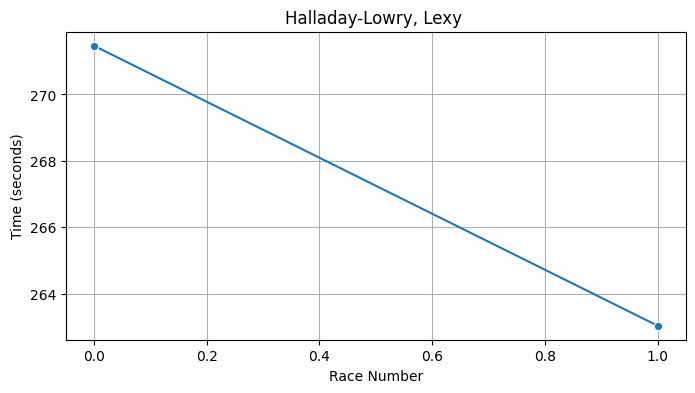

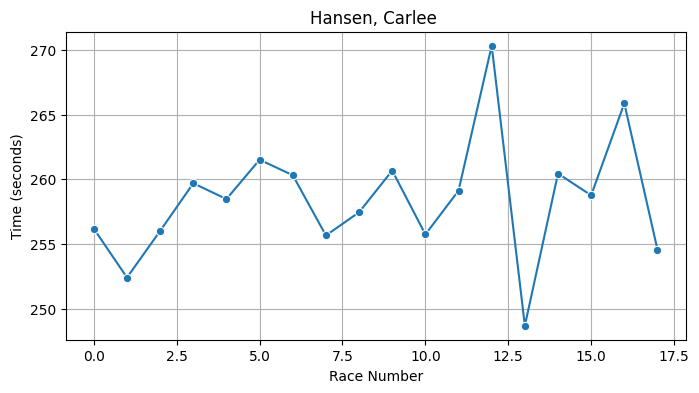

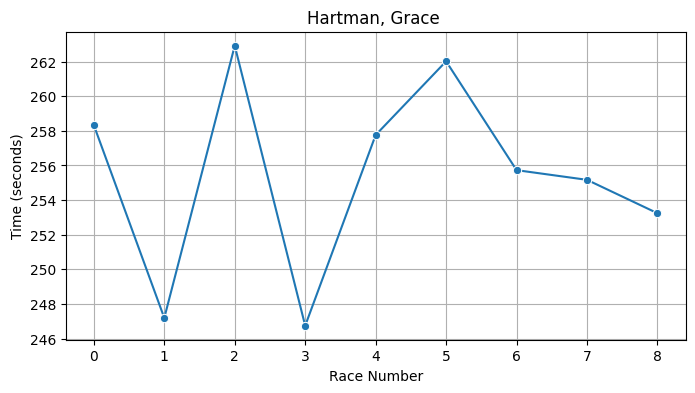

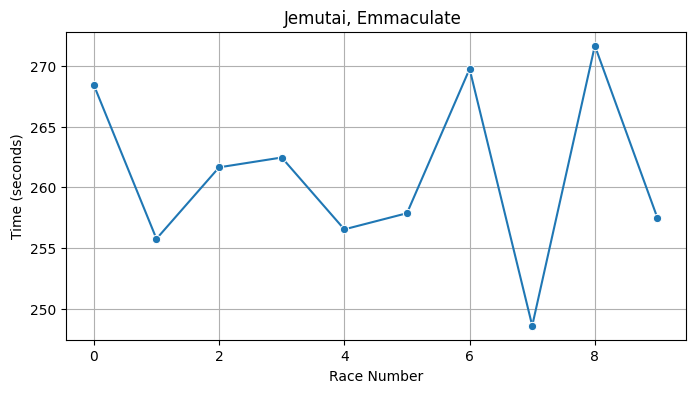

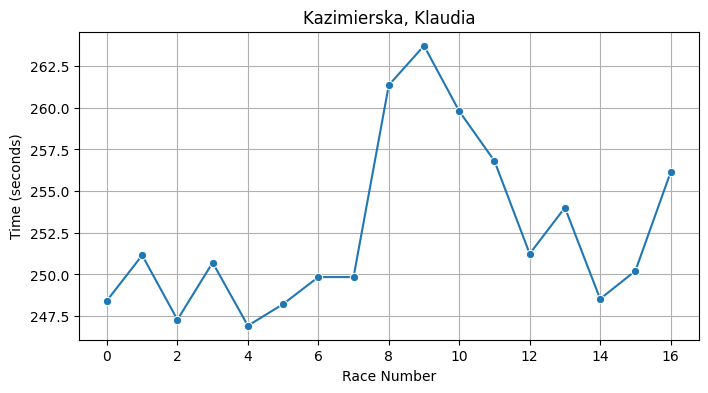

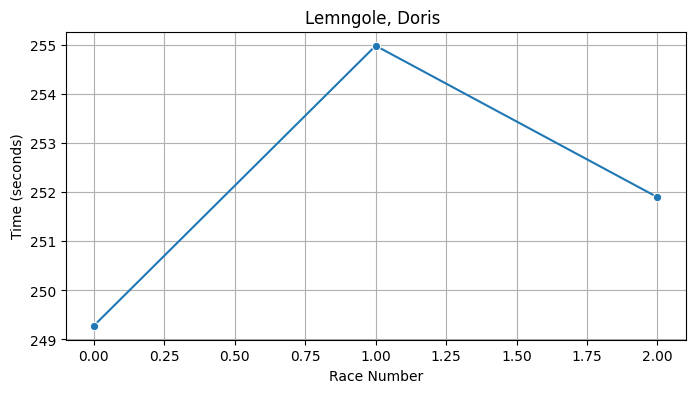

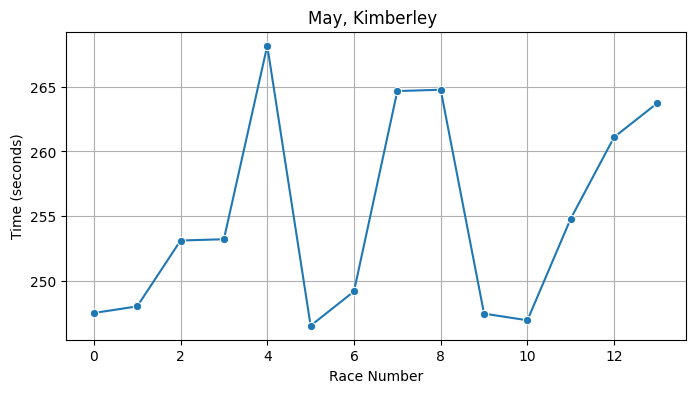

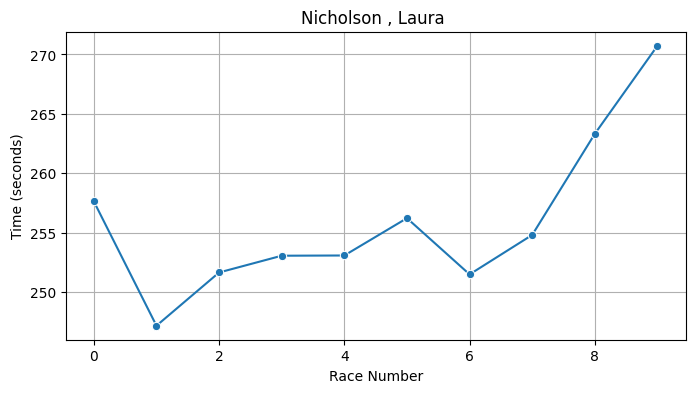

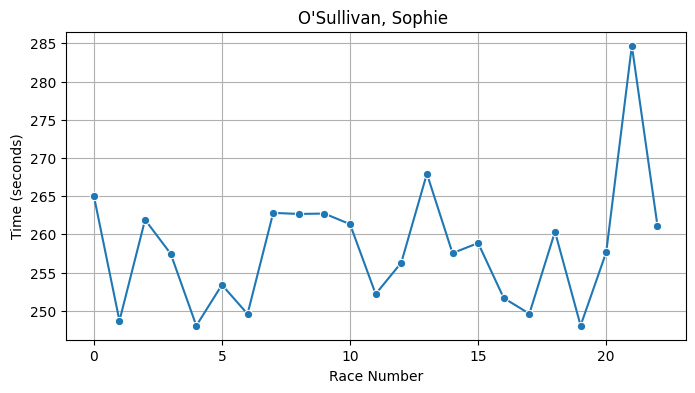

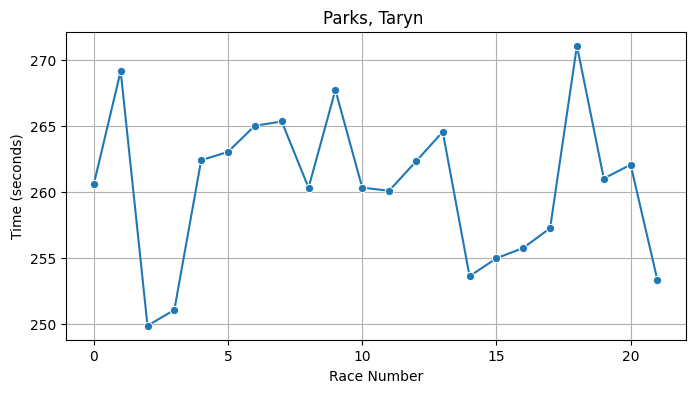

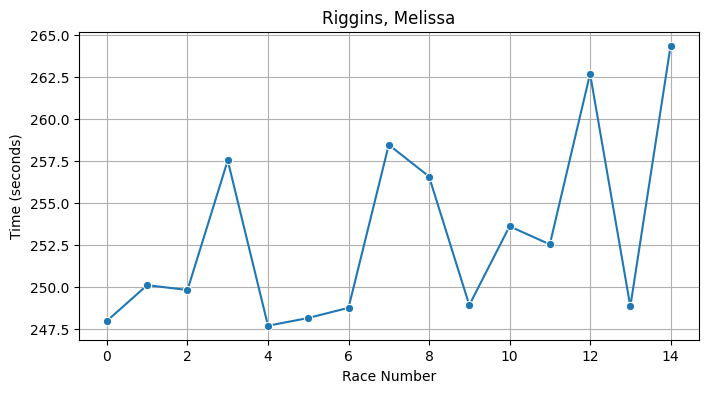

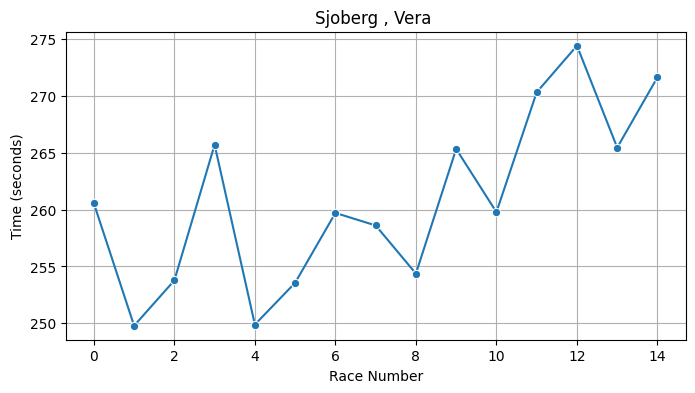

In [4]:
import seaborn as sns

# Rename column
df_clean = df_clean.rename(columns={'Name ': 'Runner'})

# Create Race_Number column
df_clean = df_clean.sort_values(by=['Runner', 'Date'])
df_clean['Race_Number'] = df_clean.groupby('Runner').cumcount()

unique_runners = df_clean['Runner'].unique()

for runner in unique_runners:
    runner_data = df_clean[df_clean['Runner'] == runner]
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=runner_data, x='Race_Number', y='Time_seconds', marker='o')
    plt.title(f"{runner}")
    plt.xlabel("Race Number")
    plt.ylabel("Time (seconds)")
    plt.grid(True)
    plt.show()

In [5]:
fastest_times = (
    df_clean.groupby('Runner')
    .agg({'Time_seconds': 'min'})
    .reset_index()
)

# Sorting from fastest to slowest
fastest_times_sorted = (
    fastest_times.sort_values(by='Time_seconds', ascending=True)
    .reset_index(drop=True)
)

# Convert seconds to MM:SS.00 format
fastest_times_sorted['Fastest_Time'] = fastest_times_sorted['Time_seconds'].apply(
    lambda x: f"{int(x//60)}:{x%60:05.2f}"
)

# Display
fastest_times_sorted

,Runner,Time_seconds,Fastest_Time
0,"Flockhart, Shannon",244.97,4:04.97
1,"Ayyildiz, Silan",245.66,4:05.66
2,"Appleton, Margo",245.68,4:05.68
3,"Foerster, Chloe",245.75,4:05.75
4,"Elbadra, Salma",245.85,4:05.85
5,"May, Kimberley",246.58,4:06.58
6,"Hartman, Grace",246.74,4:06.74
7,"Kazimierska, Klaudia",246.92,4:06.92
8,"Nicholson , Laura",247.17,4:07.17
9,"Congdon, Maggi",247.23,4:07.23


In [5]:
df_clean.columns


Index(['Runner', 'Time (minutes)', 'Event', 'Date', 'Time ', 'Date2',
       'Time_seconds', 'Race_Number'],
      dtype='object')

In [6]:

# Step 1: Sort for time-based feature creation
df_clean = df_clean.sort_values(['Runner', 'Date2'])

# Step 2: Feature engineering
df_clean['days_since'] = df_clean.groupby('Runner')['Date2'].diff().dt.days
df_clean['Avg_Pace_400m'] = df_clean['Time_seconds'] / (1500 / 400)
df_clean['Rolling_Avg_3'] = (
    df_clean.groupby('Runner')['Time_seconds']
    .rolling(window=3, min_periods=1)
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)
)

# Step 3: Compute and merge PR (personal record)
fastest_times = (
    df_clean.groupby('Runner')
    .agg({'Time_seconds': 'min'})
    .reset_index()
    .rename(columns={'Time_seconds': 'PR_Time'})
)
df_clean = df_clean.merge(fastest_times, on='Runner', how='left')

# Step 4: Calculate time from PR
df_clean['Time_from_PR'] = df_clean['Time_seconds'] - df_clean['PR_Time']

# Step 5: Create Previous_Time and Time_Change
df_clean['Previous_Time'] = df_clean.groupby('Runner')['Time_seconds'].shift(1)
df_clean['Time_Change'] = df_clean['Time_seconds'] - df_clean['Previous_Time']

# Step 6: Drop rows with missing values in needed columns
model_lm = df_clean.dropna(subset=['days_since', 'Rolling_Avg_3', 'Time_from_PR', 'Previous_Time']).copy()

# Step 7: Drop Previous_Time now that Time_Change is calculated
model_lm = model_lm.drop(columns=['Previous_Time'])

In [7]:
del model_lm['Date']

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Define features and target
features = ['days_since', 'Rolling_Avg_3', 'Time_from_PR', 'Avg_Pace_400m']
target = 'Time_Change'

# Prepare X and y
X = model_lm[features]
y = model_lm[target]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest MAE: {mae:.2f} seconds")
print(f"Random Forest R²: {r2:.3f}")


Random Forest MAE: 3.89 seconds
Random Forest R²: 0.648


In [10]:
import pickle
with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)

In [9]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(best_rf, f)


NameError: name 'best_rf' is not defined